In [1]:
# importando as libs 
import pandas as pd
import numpy as np
from ab_utils import srm_test, calculate_ci, perform_ab_test_analysis, bootstrap_ab_test, calc_prob_between, bayesian_plot, calc_beta_peak


from scipy import stats
from scipy.stats import beta

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Exploração inicial dos dados

In [2]:
ab_df = pd.read_csv("data/ab_data.csv")

In [3]:
ab_df.shape

(294478, 5)

In [4]:
# Olhando os dados
ab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [5]:
ab_df.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


In [6]:
ab_df.duplicated().sum()

0

In [7]:
ab_df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [8]:
# Calculate estatisticas gerais dos grupos e do total
conversion_rate_geral = ab_df['converted'].mean().round(4)
conversion_rate_control = ab_df.query("group == 'control'")['converted'].mean().round(4)
conversion_rate_treatment = ab_df.query("group == 'treatment'")['converted'].mean().round(4)

print("Conversion Rate Geral: ", conversion_rate_geral)
print("Conversion Rate Controle: ", conversion_rate_control)
print("Conversion Rate Tratamento: ", conversion_rate_treatment)


Conversion Rate Geral:  0.1197
Conversion Rate Controle:  0.1204
Conversion Rate Tratamento:  0.1189


### Limpeza e Preparação dos dados

In [9]:
### Verifica se há usuários duplicados
ab_df['user_id'].duplicated().sum()

3894

In [10]:
### Representatividade dos usuários duplicados no geral
ab_df['user_id'].duplicated().sum() / len(ab_df) 

0.013223398691922657

In [11]:
### Cria lista com usuários duplicados (user_id)
ids_duplicados = ab_df['user_id'].value_counts().sort_values()

### Cria uma lista com os user_id com > 1 ocorrência
ids_duplicados = ids_duplicados[ids_duplicados.values > 1].index 

### Cria novo dataframe sem os usuários duplicados
ab_df_uniques = ab_df[ab_df["user_id"].isin(ids_duplicados) == False]

### Remove colunas desnecessárias
ab_df_uniques = ab_df_uniques.drop(columns="timestamp")

### Teste de distribuição dos buckets (SRM - Sample Ratio Missmatch)

In [12]:
### Checagem inicial do balanceamento dos buckets após o tratamento de duplicados
ab_df_uniques['group'].value_counts()

treatment    143397
control      143293
Name: group, dtype: int64

In [13]:
control_count = ab_df_uniques.query("group == 'control'")['user_id'].count()
treatment_count = ab_df_uniques.query("group == 'treatment'")['user_id'].count()

In [14]:
# Roda a função para verificar o desbalanço entre grupos (Sample Ratio Missmatch)
srm_test(control_count, treatment_count, 0.005)

Diff. Entre Buckets: -104
Ratio: 0.9993
Chi-square: 0.0377
P-value: 0.8460
O teste é válido: valor-p > 0.005.


## Testes estatísticos

In [15]:
ab_summary = ab_df_uniques.pivot_table(values='converted', index='group', aggfunc=np.sum)
# add additional columns to the pivot table
ab_summary['total'] = ab_df_uniques.pivot_table(values='converted', index='group', aggfunc=lambda x: len(x))
ab_summary['conversion_rate'] = ab_df_uniques.pivot_table(values='converted', index='group')
ab_summary

,converted,total,conversion_rate
group,,,
control,17220,143293,0.120173
treatment,17025,143397,0.118726


### Exemplo de abordagem com Bootstrap 

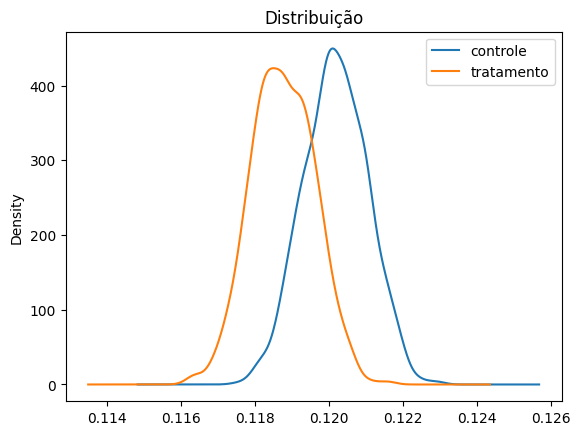

Bootstrap Diferença Observada: -0.0014
Intervalo de confiança: [-0.00374671  0.001125  ]
p-value: 0.5200
Os grupos NÃO posuem conversões estatisticamente diferentes.


,Group,Mean Conversion Rate,Confidence Interval
0,control,0.1202,"[0.1185 (-1.40%), 0.1219 (1.40%)]"
1,treatment,0.1187,"[0.1171 (-1.41%), 0.1204 (1.41%)]"


In [16]:
bootstrap_ab_test(ab_df_uniques)
calculate_ci(ab_df_uniques, "group", "converted")

### Abordagem Bayesiana

In [17]:
# Calcula o beta para os buckets
beta_C = beta(ab_df_uniques[ab_df_uniques['group'] == 'control']['converted'].sum() + 1, (1 - ab_df_uniques[ab_df_uniques['group'] == 'control']['converted']).sum() + 1)
beta_T = beta(ab_df_uniques[ab_df_uniques['group'] == 'treatment']['converted'].sum() + 1, (1 - ab_df_uniques[ab_df_uniques['group'] == 'treatment']['converted']).sum() + 1)

#Calculando o ganho do tramtamento
lift=(beta_T.mean()-beta_C.mean())/beta_C.mean()

#Calcula a probabilidade estatística do ganho visto no tste
prob=calc_prob_between(beta_T, beta_C)

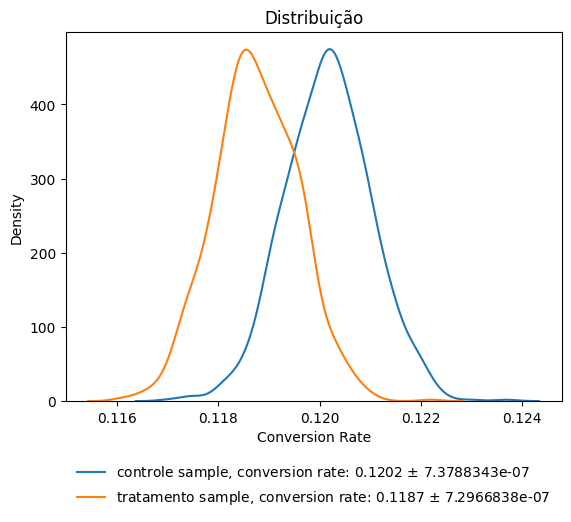

O Tratamento teve um efeito de -1.20% na métrica selecionada com 11.6% de probabilidade de perder para o controle.


In [18]:
bayesian_plot([beta_C, beta_T], names=["controle", "tratamento"], data=ab_df_uniques, group_column='group', converted_column='converted', linf=0.1, lsup=0.14)

# Printa o resultado
if lift < 0:
    print (f"O Tratamento teve um efeito de {lift*100:2.2f}% na métrica selecionada com {prob*100:2.1f}% de probabilidade de perder para o controle.")
else:
    print (f"O Tratamento teve um efeito de {lift*100:2.2f}% na métrica selecionada com {prob*100:2.1f}% de probabilidade de ganhar do controle.")
                

### Conclusões
README